### Import Libraries

In [1]:
import pickle
import seaborn as sns
import pandas as pd
import itertools
import numpy as np
import re, nltk, spacy, gensim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, make_scorer, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.svm import LinearSVC
from matplotlib.collections import LineCollection
from nltk.tokenize import ToktokTokenizer
from nltk.stem import wordnet
from nltk.corpus import stopwords
from string import punctuation

c:\python36\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Wordnet & stopwords

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SRKT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SRKT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Read Dataset

In [3]:
df  = pd.read_csv(r"C:\Users\SRKT\Downloads\SE-Dataset.csv")

In [90]:
df.head()

,Body,Tags
0,work java webapplication application user xlsp...,"[java, architecture, performance]"
1,firstly software engineering question question...,"[design-patterns, python, object-oriented-design]"
2,programmer document codesystem uml especially ...,"[design, development-process, programming-prac..."
3,subproject github repo convenience user actual...,"[licensing, github]"
4,point much solid htmlcss js programmer pick pr...,"[web, file-handling, storage]"


In [91]:
df  = df.iloc[:,-2:]
df.head()

,Body,Tags
0,work java webapplication application user xlsp...,"[java, architecture, performance]"
1,firstly software engineering question question...,"[design-patterns, python, object-oriented-design]"
2,programmer document codesystem uml especially ...,"[design, development-process, programming-prac..."
3,subproject github repo convenience user actual...,"[licensing, github]"
4,point much solid htmlcss js programmer pick pr...,"[web, file-handling, storage]"


### Count total number of tags

In [6]:
def Total_tag(data, reference_col, all_Words): 

    count_k = dict()
    index = -1
    
    for s in all_Words: 
        count_k[s] = []
        count_k[s].append(0)
        count_k[s].append(0)
        
    for all_keywords in data[reference_col].str.split('>'): 
        
        if type(all_keywords) == float and pd.isnull(all_keywords): 
            continue
        
        index += 1
            
        for s in [s for s in all_keywords if s in all_Words]: 
            if pd.notnull(s):
                count_k[s][0] += 1
                    
    word_occurence = []
    
    for tag, item in count_k.items():
        word_occurence.append([tag[1:], item[0], item[1]/item[0]])
        
    word_occurence.sort(key = lambda x:x[1], reverse = True)
    
    return word_occurence

### Making list for different tags

In [7]:
tag_add = set()
scoring = list()

for all_keywords in df['Tags'].str.split('>').values:
    
    if isinstance(all_keywords, float): 
        continue 
    tag_add = tag_add.union(all_keywords)    
print('There are %d tags' % len(tag_add))

There are 1614 tags


### Most Common Tags

In [9]:
word_occurence = Total_tag(df, 'Tags', tag_add)
temp_occure = word_occurence[1:401]
top_tags = [i[0] for i in temp_occure]

def common_tag(tags):
    clean_tags = str(tags).split('>')[:-1]
    filtered_tags = []
    
    for tag in clean_tags:
        
        if tag[1:] in top_tags:
            filtered_tags.append(tag[1:])
            
    return filtered_tags

### Apply methods for tags

In [10]:
df['Tags'] = df['Tags'].apply(lambda x: common_tag(x))
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [11]:
df

,Body,Tags
0,<p>I work on a java web-application.\nIn this ...,"[java, architecture, performance]"
1,<p><em>Firstly I am new to Software Engineerin...,"[design-patterns, python, object-oriented-design]"
2,<p>As much as programmers hate to document the...,"[design, development-process, programming-prac..."
3,<p>I want to gather several sub-projects in a ...,"[licensing, github]"
4,"<p>At this point, I'm not much of a programmer...","[web, file-handling, storage]"
...,...,...
29995,<p>I have a web service with the methods <code...,"[c#, naming, web-services]"
29996,<p>I'm producing a binary distributable for my...,"[java, licensing, mit-license, maven, apache-l..."
29997,<p>Now this question might sound (/ is) stupid...,[graphics]
29998,<p>In a website users can register through dif...,"[design-patterns, database-design]"


In [12]:
df.dropna(subset=['Tags'], inplace=True)
df.shape

(29113, 2)

In [13]:
df.head()

,Body,Tags
0,<p>I work on a java web-application.\nIn this ...,"[java, architecture, performance]"
1,<p><em>Firstly I am new to Software Engineerin...,"[design-patterns, python, object-oriented-design]"
2,<p>As much as programmers hate to document the...,"[design, development-process, programming-prac..."
3,<p>I want to gather several sub-projects in a ...,"[licensing, github]"
4,"<p>At this point, I'm not much of a programmer...","[web, file-handling, storage]"


### Pre-processing Data

In [14]:
def data_clean(text):
 
    text = text.lower()
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [15]:
df['Body'] = df['Body'].apply(lambda x: data_clean(x))

In [16]:
df

,Body,Tags
0,<p>i work on a java web-application. in this a...,"[java, architecture, performance]"
1,<p><em>firstly i am new to software engineerin...,"[design-patterns, python, object-oriented-design]"
2,<p>as much as programmers hate to document the...,"[design, development-process, programming-prac..."
3,<p>i want to gather several sub-projects in a ...,"[licensing, github]"
4,"<p>at this point, i'm not much of a programmer...","[web, file-handling, storage]"
...,...,...
29995,<p>i have a web service with the methods <code...,"[c#, naming, web-services]"
29996,<p>i'm producing a binary distributable for my...,"[java, licensing, mit-license, maven, apache-l..."
29997,<p>now this question might sound (/ is) stupid...,[graphics]
29998,<p>in a website users can register through dif...,"[design-patterns, database-design]"


In [17]:
df['Body'] = df['Body'].apply(lambda x: BeautifulSoup(x).get_text())

In [18]:
df

,Body,Tags
0,i work on a java web-application. in this appl...,"[java, architecture, performance]"
1,firstly i am new to software engineering and m...,"[design-patterns, python, object-oriented-design]"
2,as much as programmers hate to document their ...,"[design, development-process, programming-prac..."
3,i want to gather several sub-projects in a sin...,"[licensing, github]"
4,"at this point, i'm not much of a programmer, s...","[web, file-handling, storage]"
...,...,...
29995,i have a web service with the methods getuser ...,"[c#, naming, web-services]"
29996,i'm producing a binary distributable for my ja...,"[java, licensing, mit-license, maven, apache-l..."
29997,"now this question might sound (/ is) stupid, b...",[graphics]
29998,in a website users can register through differ...,"[design-patterns, database-design]"


In [19]:
token = ToktokTokenizer()
punct = punctuation

In [20]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)   
    return [item for item in newlist if item != '']

### Remove all Punctuation

In [21]:
def punctuation_remove (text): 
    words = token.tokenize(text)
    data_wo_Punctuation = []
    regex = re.compile('[%s]' % re.escape(punct))
    replace_punct = str.maketrans(' ', ' ', punct)
    
    for w in words:
        if w in top_tags:
            data_wo_Punctuation.append(w)
        else:
            w = re.sub('^[0-9]*', " ", w)
            data_wo_Punctuation.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(data_wo_Punctuation)
        
    return ' '.join(map(str, filtered_list))

In [22]:
stop_words = set(stopwords.words("english"))

### Remove all Stop-Words

In [23]:
def remove_stopWords(text):
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]    
    return ' '.join(map(str, filtered))

### Wordnet lemmatizing

In [25]:
nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatizing(texts, allowed_postags, stop_words=stop_words):
   
    lemma = wordnet.WordNetLemmatizer()       
    doc = nlp(texts) 
    result_data = []
    
    for token in doc:    
        if str(token) in top_tags:
            result_data.append(str(token))           
        elif token.pos_ in allowed_postags:           
            if token.lemma_ not in ['-PRON-']:
                result_data.append(token.lemma_)             
            else:
                result_data.append('')     
    result_data = ' '.join(result_data)

    return result_data

In [26]:
df['Body'] = df['Body'].apply(lambda x: punctuation_remove (x)) 
df['Body'] = df['Body'].apply(lambda x: remove_stopWords(x)) 
df['Body'] = df['Body'].apply(lambda x: lemmatizing(x, ['NOUN', 'ADV']))

In [27]:
df

,Body,Tags
0,work java webapplication application user xlsp...,"[java, architecture, performance]"
1,firstly software engineering question question...,"[design-patterns, python, object-oriented-design]"
2,programmer document codesystem uml especially ...,"[design, development-process, programming-prac..."
3,subproject github repo convenience user actual...,"[licensing, github]"
4,point much solid htmlcss js programmer pick pr...,"[web, file-handling, storage]"
...,...,...
29995,web service methods getuser adduser dtos data ...,"[c#, naming, web-services]"
29996,binary java project way maven code project apa...,"[java, licensing, mit-license, maven, apache-l..."
29997,question glfw source example code still functi...,[graphics]
29998,website user login facebook github addition em...,"[design-patterns, database-design]"


### Vectorization and Traing Testing Split

In [29]:
X_vec = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                   strip_accents = None, encoding = 'utf-8', 
                                   preprocessor=None, 
                                   token_pattern=r"(?u)\S\S+", 
                                   max_features=1000)
multilabel_binarizer = MultiLabelBinarizer()
y_tags = multilabel_binarizer.fit_transform(df['Tags'])

X_train, X_test, y_train, y_test = train_test_split(
    df['Body'], y_tags, test_size=0.2,train_size=0.8, random_state=0)

X_tfidf_train = X_vec.fit_transform(X_train)
X_tfidf_test = X_vec.transform(X_test)

### Vectorization with 2gram TF-IDF

In [30]:
2gram_vec = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                   strip_accents = None, encoding = 'utf-8', 
                                   preprocessor=None, ngram_range=(2,2),
                                   token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                   max_features=1000)
X_2gram_train, X_2gram_test, y_2gram_train, y_2gram_test = train_test_split(
    df['Body'], df['Tags'], test_size=0.2,train_size=0.8, random_state=0)

X_2gram_tfidf_train = 2gram_vec.fit_transform(X_2gram_train)
X_2gram_tfidf_test = 2gram_vec.transform(X_2gram_test)

In [31]:
y_tags

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
X_2gram_tfidf_train

<23290x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 82958 stored elements in Compressed Sparse Row format>

### Print top words

In [38]:
def common_words(model, feature_names, number_words_best, data):
    list_topics = []
    list_occurences = []
    topics_num = model.n_components

    for i in model.transform(data):
        list_topics.append(i.argmax())
    
    for topic in range(topics_num):
        list_occurences.append(list_topics.count(topic))

    top_topics = sorted(range(len(list_occurences)), 
                        key=lambda k: list_occurences[k], reverse=True)
    
    for topic_idx, topic_id in zip(range(1, topics_num + 1), top_topics):
        message = "Tag #%d: " % topic_idx
        message += " / ".join([feature_names[i]
                             for i in model.components_[topic_id].argsort()[:-number_words_best - 1:-1]])
        print(message)
    
    print()

### Topic Modelling with LDA

In [39]:
def lda(vectorizer, data_train, data_test):
    number_words_best = 15
    perplexity_high = np.inf
    lda_high = 0
    print("Extracting term frequency features for LDA...")
    perplexity_list = []
    number_topic = []
    for topics_num in np.linspace(10, 50, 5, dtype='int'):
        lda_model = LatentDirichletAllocation(n_components=topics_num, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(data_train)
        number_topic.append(topics_num)
        perplexity = lda_model.perplexity(data_test)
        perplexity_list.append(perplexity)
        if perplexity <= perplexity_high:
            perplexity_high = perplexity
            lda_high = lda_model
                                
    plt.title("Evolution of perplexity score depending on number of topics")
    plt.xlabel("Number of topics")
    plt.ylabel("Perplexity")
    plt.plot(number_topic, perplexity_list)
    plt.show()

    print("\n The tags in the LDA model :")
    tf_feature_names = vectorizer.get_feature_names()
    common_words(lda_high, tf_feature_names, number_words_best, data_test)

Extracting term frequency features for LDA...


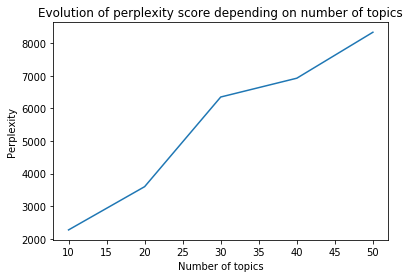


 The tags in the LDA model :
Tag #1: project / code / test / developer / team / software / development / time / work / company / testing / question / feature / version / branch
Tag #2: function / code / language / value / type / example / programming / languages / class / number / int / functions / array / object / algorithm
Tag #3: server / data / user / web / application / client / database / app / api / service / file / page / request / system / way
Tag #4: class / object / method / interface / methods / model / pattern / code / data / entity / property / test / type / logic / layer
Tag #5: user / string / error / null / exception / email / class / return / name / message / object / value / function / method / item
Tag #6: license / source / file / project / library / gpl / code / software / copyright / libraries / program / folder / use / version / card
Tag #7: table / database / node / column / query / sql / data / row / tree / record / graph / schema / child / mysql / category
T

In [40]:
lda(X_vec, X_tfidf_train, X_tfidf_test)

In [45]:
y_tags[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### recommend tag lda

In [56]:
def Recommend_tags_lda_test(X_tfidf_test, X_train):
    dataframe_lda_tt = pd.DataFrame(index=[i for i in range(X_tfidf_test.shape[0])], 
             columns=['0.010', '0.011', '0.012', '0.013'])
    corpus = X_tfidf_test
    topics_num = 10

    string_vectorizer = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
    X_tfidf_train = string_vectorizer.fit_transform(X_train)
    lda_model = LatentDirichletAllocation(n_components=topics_num, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)
    corpus_projection = lda_model.transform(corpus)
    
    feature_names = string_vectorizer.get_feature_names()
    ldaElement = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for column, threshold in zip(range(4), [0.010, 0.011, 0.012, 0.013]): #  threshold to exceed to be considered as a relevant tag

        for text in range(corpus.shape[0]):
            list_scores = []
            list_words = []

            for topic in range(topics_num):
                topic_score = corpus_projection[text][topic]

                for (word_idx, word_score) in zip(ldaElement[topic].argsort()[:-5:-1], sorted(ldaElement[topic])[:-5:-1]):
                    score = topic_score*word_score

                    if score >= threshold:
                        list_scores.append(score)
                        list_words.append(feature_names[word_idx])

            results = [tag for (y,tag) in sorted(zip(list_scores,list_words), 
                                                 key=lambda pair: pair[0], reverse=True)]
            dataframe_lda_tt.iloc[text, column] = results[:5] #maximum five tags

    return dataframe_lda_tt

In [57]:
def Recommend_tags_lda(text, X_train):
    text = data_clean(text)
    text = punctuation_remove (text)
    text = remove_stopWords(text)
    text = lemmatizing(text, ['NOUN', 'ADV'])
    topics_num = 10
    threshold = 0.011
    list_scores = []
    list_words = []
    used = set()

    string_vectorizer = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                    max_features=1000)
    string_vectorizer.fit(X_train)
    text_tfidf = string_vectorizer.transform([text])

    lda_model = LatentDirichletAllocation(n_components=topics_num, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)
    text_projection = lda_model.transform(text_tfidf)
    feature_names = string_vectorizer.get_feature_names()
    ldaElement = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    for topic in range(topics_num):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(ldaElement[topic].argsort()[:-5:-1], sorted(ldaElement[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    unique_results = [x for x in results if x not in used] # get only unique tags
    tags = " ".join(results[:5])

    return tags

In [58]:
dataframe_lda_tt = Recommend_tags_lda_test(X_tfidf_test, X_train)

In [59]:
dataframe_lda_tt.head(10)

,0.010,0.011,0.012,0.013
0,[],[],[],[]
1,"[server, data, user, web]","[server, data, user]","[server, data, user]","[server, data]"
2,[function],[],[],[]
3,[user],[user],[user],[user]
4,"[server, data, user, web]","[server, data, user]","[server, data, user]","[server, data]"
5,"[server, data, user]","[server, data, user]","[server, data]",[server]
6,"[class, object]",[class],[class],[class]
7,"[foo, bar, android, app]","[foo, bar, android, app]","[foo, bar, android, app]","[foo, bar, android, app]"
8,[],[],[],[]
9,[],[],[],[]


### statistic of tags

In [60]:
tag_med = np.median(df['Tags'].apply(lambda x: len(x)))
tag_mean = np.mean(df['Tags'].apply(lambda x: len(x)))
print('Average number of tags in the training set: %.2f' % tag_mean)
print('Median number of tags in the training set: ', tag_med)
print('--------------------------------------')

for threshold in dataframe_lda_tt.columns:
    print('Average number of tags in the test set, with a threshold of %s: %.2f' 
          % (threshold, np.mean(dataframe_lda_tt[threshold].apply(lambda x: len(x)))))
    print('Median number of tags in the test set, with a threshold of %s: %d' %
          (threshold, np.median(dataframe_lda_tt[threshold].apply(lambda x: len(x)))))
    print('Percentage of posts that have recommended tags in the test set, with a threshold of %s: %d' %
          (threshold, np.sum(dataframe_lda_tt[threshold].apply
                             (lambda x: 1 if len(x)!=0 else 0))*100/dataframe_lda_tt.shape[0]))
    print('--------------------------------------')

Average number of tags in the training set: 2.41
Median number of tags in the training set:  2.0
--------------------------------------
Average number of tags in the test set, with a threshold of 0.010: 2.46
Median number of tags in the test set, with a threshold of 0.010: 3
Percentage of posts that have recommended tags in the test set, with a threshold of 0.010: 87
--------------------------------------
Average number of tags in the test set, with a threshold of 0.011: 1.82
Median number of tags in the test set, with a threshold of 0.011: 2
Percentage of posts that have recommended tags in the test set, with a threshold of 0.011: 75
--------------------------------------
Average number of tags in the test set, with a threshold of 0.012: 1.38
Median number of tags in the test set, with a threshold of 0.012: 1
Percentage of posts that have recommended tags in the test set, with a threshold of 0.012: 63
--------------------------------------
Average number of tags in the test set, with 

In [61]:
def tags_lda_test(X_tfidf_test, X_train):
    dataframe_lda_tt = pd.DataFrame(index=[i for i in range(X_tfidf_test.shape[0])], 
             columns=['Tags_test'])
    corpus = X_tfidf_test
    list_results = []
    topics_num = 10
    threshold = 0.010

    string_vectorizer = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                    strip_accents = None, encoding = 'utf-8', 
                                    preprocessor=None, 
                                    token_pattern=r"(?u)\S\S+", 
                                    max_features=1000)
    X_tfidf_train = string_vectorizer.fit_transform(X_train)
    lda_model = LatentDirichletAllocation(n_components=topics_num, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(X_tfidf_train)
    corpus_projection = lda_model.transform(corpus)
    feature_names = string_vectorizer.get_feature_names()
    ldaElement = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis] 
    for text in range(corpus.shape[0]):
        list_scores = []
        list_words = []

        for topic in range(topics_num):
            topic_score = corpus_projection[text][topic]

            for (word_idx, word_score) in zip(ldaElement[topic].argsort()[:-5:-1], sorted(ldaElement[topic])[:-5:-1]):
                score = topic_score*word_score

                if score >= threshold:
                    list_scores.append(score)
                    list_words.append(feature_names[word_idx])

        results = [tag for (y,tag) in sorted(zip(list_scores,list_words),
                                             key=lambda pair: pair[0], reverse=True)][:5] 
        list_results.append(results)
    
    tag_prediction_lda = pd.DataFrame({'tags':list_results})

    return tag_prediction_lda

In [62]:
def avg_jaccard(y_true,tag_prediction):
    jacard = np.minimum(y_true,tag_prediction).sum(axis=1) / np.maximum(y_true,tag_prediction).sum(axis=1)
    
    return jacard.mean()*100

### using one vs all machine learining model to train

In [63]:
OvR_Class = OneVsRestClassifier(DummyClassifier(random_state=0))
OvR_Class.fit(X_tfidf_train, y_train)
tag_prediction = OvR_Class.predict(X_tfidf_test)
jaccard = avg_jaccard(y_test, tag_prediction)
print('Jaccard score in percentage for Dummy Classifier: %.2f ' % jaccard)

Jaccard score in percentage for Dummy Classifier: 0.38 


In [64]:
tag_prediction = tags_lda_test(X_tfidf_test, X_train)
tag_prediction = multilabel_binarizer.transform(tag_prediction['tags'])
jaccard_score(y_test, tag_prediction, average='samples')
jaccard = avg_jaccard(y_test, tag_prediction)
print('Jaccard score in percentage for LDA recommender system: %.2f ' % jaccard)

Jaccard score in percentage for LDA recommender system: 0.93 


In [66]:
Question = input('Ask a question: ')
tags = Recommend_tags_lda(Question, X_train)
print('Recommended tags are:', tags)

Ask a question: linq query web service usually business tier return transport linq query way linq query result linq query alternatively linq query serializable expose web service
Recommended tags are: table database node


### Classification using OneVsRestClassifier with Linear SVC

Best hyperparameters on the training set: {'estimator__C': 10.0}
jaccard score : 19.1210


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F871310550>,
      dtype=object)

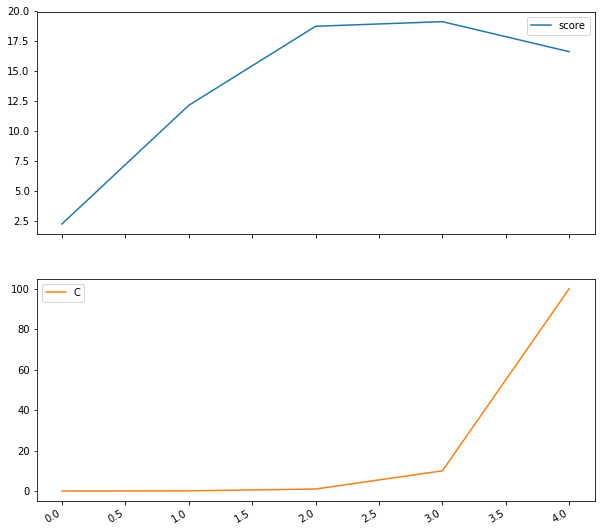

In [67]:
clf_svc = OneVsRestClassifier(LinearSVC(random_state=0))
param_grid = {'estimator__C':np.logspace(-2, 2, 5)}

inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
clf_svc_gs = GridSearchCV(clf_svc, param_grid, cv=inner_cv,
                            scoring=make_scorer(avg_jaccard,greater_is_better=True))
clf_svc_gs.fit(X_tfidf_train, y_train)
nested_score = cross_val_score(clf_svc_gs, X=X_tfidf_train, y=y_train, cv=outer_cv)

print("Best hyperparameters on the training set:",
      clf_svc_gs.best_params_)
print("jaccard score : %.4f" % nested_score.mean())
    
clf_svc_gs_df=pd.DataFrame(np.transpose([clf_svc_gs.cv_results_['mean_test_score'],
                                     clf_svc_gs.cv_results_['param_estimator__C'].data]),
                           columns=['score', 'C'])
clf_svc_gs_df.plot(subplots=True,figsize=(10, 10))

In [68]:
clf_svc_gs = OneVsRestClassifier(LinearSVC(random_state=0, C=1.0))
clf_svc_gs.fit(X_tfidf_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(random_state=0))

In [69]:
clf_svc_gs = OneVsRestClassifier(LinearSVC(random_state=0, C=1.0))
clf_svc_gs.fit(X_tfidf_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(random_state=0))

### Neural Network

In [72]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [118]:
model = Sequential()
model.add(Dense(600, activation='relu', input_shape=(1000,)))
model.add(Dense(400, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_2gram_tfidf_train, y_train, epochs=4, batch_size=2048)

Epoch 1/4
23290/23290 [==============================] - 1s 63us/sample - loss: 14.2708 - acc: 0.0330
Epoch 2/4
23290/23290 [==============================] - 1s 41us/sample - loss: 13.9348 - acc: 0.0755
Epoch 3/4
23290/23290 [==============================] - 1s 40us/sample - loss: 13.3907 - acc: 0.0812
Epoch 4/4
23290/23290 [==============================] - 1s 42us/sample - loss: 12.9005 - acc: 0.0745
